In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

import lightkurve as lk
from wotan import flatten, transit_mask

import pandas as pd
import astropy.units as u

from brokenaxes import brokenaxes

import exoplanet as xo
import pymc3 as pm
import pymc3_ext as pmx
import aesara_theano_fallback.tensor as tt

from scipy.stats import binned_statistic

import arviz as az
import corner
import os

from astroquery.mast import Catalogs
from tess_stars2px import tess_stars2px_function_entry

In [2]:
def get_mad(data):
    return np.nanmedian(np.abs(data - np.nanmedian(data)))

def get_phase(t, per, epo):
    phase = np.mod(t - epo, per)/per
    phase[phase > 0.5] -= 1
    return phase

def get_mask(t, per, epo, dur):
    phase = get_phase(t, per, epo)
    neartran = (abs(phase) < 2*dur/per)
    return neartran

def get_oe(t, per, epo, dur):
    phase2 = np.mod(t - epo, 2*per)/per
    phase2[phase2 > 1] -= 2
    odd_tran = (abs(phase2) < 0.5*dur/per)
    even_tran = (abs(phase2) > 1 - 0.5*dur/per)
    return odd_tran, even_tran

def get_median(s):
    med = np.median(s)
    upp = np.percentile(s,84.1)-med
    low = med-np.percentile(s,15.9)
    return med, low, upp


In [3]:
tic = 397362481
npl = 3

param_file = f"{tic}.params"
df = pd.read_csv(param_file)

lcfile = f"{tic}_lc.csv"
lc = pd.read_csv(lcfile,index_col=False)
time = lc["time"].values
flux = lc["flux"].values
err = lc["err"].values
texp = lc["texp"].values

# to try to ignore the first transit
mask = time > 3015
time = time[mask]
flux = flux[mask]
err = err[mask]
texp = texp[mask]

In [4]:
per = np.array([np.median(df[f"period_{i}"]) for i in range(npl)])
epo = np.array([np.median(df[f"epoch_{i}"]) for i in range(npl)])
dur = np.array([np.median(df[f"dur_{i}"]) for i in range(npl)])/24.
rprs = np.array([np.median(df[f"rprs_{i}"]) for i in range(npl)])
b = np.array([np.median(df[f"b_{i}"]) for i in range(npl)])

print(per, epo, dur, rprs, b)

[4.46568817 6.20400656 7.87079398] [3014.84932544 3017.11400412 3018.56976659] [0.07160377 0.0721739  0.05901239] [0.01326063 0.01356825 0.01334236] [0.2804248  0.52794141 0.77976261]


In [5]:
catalog_data = Catalogs.query_object(f"TIC {tic}", catalog="TIC")
row = catalog_data[0]

ra = row["ra"]
dec = row["dec"]

M_star = row["mass"], row["e_mass"]
R_star = row["rad"], row["e_rad"]
Teff = row["Teff"], row["e_Teff"]
print(M_star[0], R_star[0], Teff[0])

_, _, _, outSec, outCam, outCcd, _, _, _ = tess_stars2px_function_entry(tic, ra, dec)
print(outSec, outCam, outCcd)

0.74 0.630715 4633.87
[63 64] [2 2] [3 4]


In [6]:
M_star = [0.65, 0.16]
R_star = [0.63, 0.16]
Teff = [4675, 53]

In [7]:
sec120 = {}
sec120["name"] = "120sec"
sec120["time"] = time[texp == 120]
sec120["flux"] = flux[texp == 120]
sec120["err"] = err[texp == 120]
sec120["texp"] = 120/60/60/24.

sec200 = {}
sec200["name"] = "200sec"
sec200["time"] = time[texp == 200]
sec200["flux"] = flux[texp == 200]
sec200["err"] = err[texp == 200]
sec200["texp"] = 200/60/60/24.

sec600 = {}
sec600["name"] = "600sec"
sec600["time"] = time[texp == 600]
sec600["flux"] = flux[texp == 600]
sec600["err"] = err[texp == 600]
sec600["texp"] = 600/60/60/24.

sec1800 = {}
sec1800["name"] = "1800sec"
sec1800["time"] = time[texp == 1800]
sec1800["flux"] = flux[texp == 1800]
sec1800["err"] = err[texp == 1800]
sec1800["texp"] = 1800/60/60/24.

insts = []
for inst in [sec120, sec200, sec600, sec1800]:
    if len(inst["time"]) == 0:
        continue
    mask = np.zeros_like(inst["time"]).astype(bool)
    for i in range(len(per)):
        mask |= get_mask(inst["time"], per[i], epo[i], dur[i])
    inst["time"] = inst["time"][mask]
    inst["flux"] = inst["flux"][mask]
    inst["err"] = inst["err"][mask]
    insts.append(inst)
    print("Added {}".format(inst["name"]))
    
t_plot = np.array([])
dt = min(dur)/100
for e, d in zip(epo, dur):
    t1 = np.arange(e-2.5*d, e+2.5*d, dt)
    t_plot = np.concatenate((t_plot, t1))

Added 120sec


In [8]:
all_transit_times = xo.orbits.ttv.compute_expected_transit_times(
    time.min(), time.max(), per, epo
)

obs_transit_times = []
transit_inds = []
for i in range(npl):
    all_times = all_transit_times[i]
    phase = get_phase(time, per[i], epo[i])
    in_tran = (abs(phase) < 0.5*dur[i]/per[i])
    epochs = np.round((time - epo[i])/per[i])
    obs_epochs = np.unique(epochs[in_tran])
    obs_times = epo[i] + obs_epochs*per[i]
    idx = list(np.argwhere(np.isin(all_times, obs_times)).flatten())
    obs_transit_times.append(list(obs_times))
    transit_inds.append(idx)

In [9]:
with pm.Model() as model:

    ############### Physical/orbital fit parameters ###############
    ror = pm.Uniform("ror", lower=0, upper=0.5, testval=rprs, shape=npl)    
    b = pm.Uniform("b", lower=0, upper=1, testval=b, shape=npl)
    #b = xo.distributions.ImpactParameter("b", ror=ror, shape=npl)  
    
    r_pl = pm.Deterministic("r_pl", ror * R_star[0])
    
    ############### Transit times ###############
    
    transit_times = []
    for i in range(npl):
        transit_times.append(
            pm.Uniform(
                "tts_{0}".format(i),
                lower=[t-0.25 for t in obs_transit_times[i]],
                upper=[t+0.25 for t in obs_transit_times[i]],
                shape=len(obs_transit_times[i]),
                testval=obs_transit_times[i]
            )
        )
    
    ############### Define the orbit ###############
    orbitTransit = xo.orbits.TTVOrbit(
        b=b,
        transit_times=transit_times,
        transit_inds=transit_inds, 
        r_star=R_star[0],
        m_star=M_star[0])   
    
    # For tracking
    pm.Deterministic("t0", orbitTransit.t0)
    pm.Deterministic("P", orbitTransit.period)
    for i in range(npl):
        pm.Deterministic("ttvs_{0}".format(i), orbitTransit.ttvs[i])

    ############### Set up lightcurves ###############
    tess_u = xo.QuadLimbDark("tess_star")
    tess_star = xo.LimbDarkLightCurve(tess_u)

    for inst in insts:
        name = inst["name"]
        mean = pm.Uniform(name+"_mean", lower=-0.01, upper=0.01, testval=0)
        sigma = pm.Uniform(name+"_sigma", lower=0, upper=0.01, testval=np.std(inst["flux"]))
        resid = inst["flux"] - mean
 
        def lc_model(x, texp, n=""):
            lcs = tess_star.get_light_curve(orbit=orbitTransit, r=r_pl, t=x, texp=texp, oversample=3)
            pm.Deterministic(name+"_lc"+n, lcs)
            return pm.Deterministic(name+"_lc_model"+n, tt.sum(lcs,axis=-1))
        
        lc_model(t_plot, dt, "_plot")
        lc = lc_model(inst["time"], inst["texp"])
        pm.Normal(name+"_obs", mu=lc, sd=tt.sqrt(inst["err"]**2 + sigma**2), observed=resid - 1)

    ############### Optimize fit ###############
    map_soln = model.test_point
    map_soln = pmx.optimize(start=map_soln, vars=transit_times)
    map_soln = pmx.optimize(start=map_soln, vars=[ror, b])
    map_soln = pmx.optimize(start=map_soln, vars=transit_times)
    map_soln = pmx.optimize(start=map_soln)


optimizing logp for variables: [tts_2, tts_1, tts_0]


message: Desired error not necessarily achieved due to precision loss.
logp: 34430.731346684865 -> 34446.67839506391
optimizing logp for variables: [b, ror]


message: Desired error not necessarily achieved due to precision loss.
logp: 34446.67839506391 -> 34449.92892792724
optimizing logp for variables: [tts_2, tts_1, tts_0]


message: Desired error not necessarily achieved due to precision loss.
logp: 34449.92892792724 -> 34450.941144729186
optimizing logp for variables: [120sec_sigma, 120sec_mean, tess_star, tts_2, tts_1, tts_0, b, ror]


message: Desired error not necessarily achieved due to precision loss.
logp: 34450.941144729186 -> 34791.121006956135


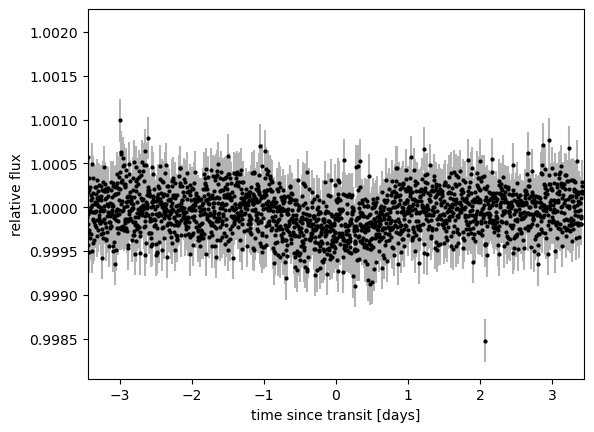

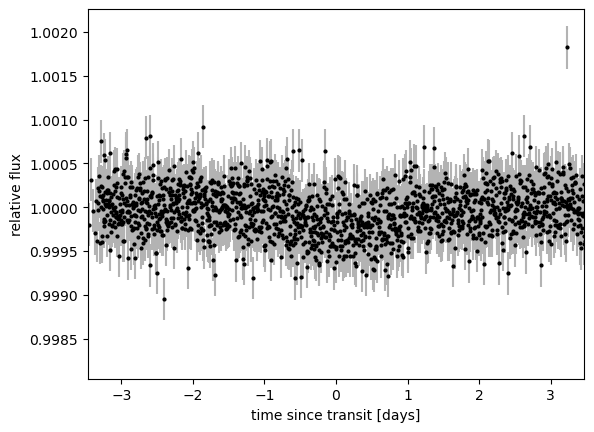

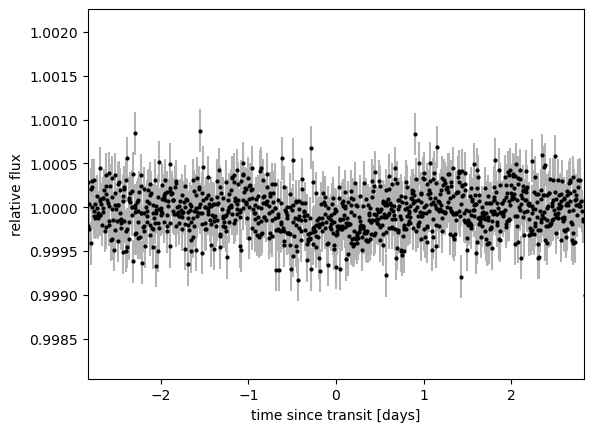

In [10]:
ms = 4
ecolor="0.7"

for i, letter in enumerate("bcd"):
    plt.figure()

    p = map_soln["P"][i]
    t0 = map_soln["t0"][i]
    
    # Plot the folded light curve
    for inst in insts:
        name = inst["name"]
        mu = map_soln[name+"_mean"]
        sigma = map_soln[name+"_sigma"]
        lcs = map_soln[name+"_lc"]
        if npl > 1:
            other = lcs[:,(i+1) % npl]
        else:
            other = 0
        lc_fold = (inst["time"] - t0 + 0.5*p) % p - 0.5*p
        lc_flux = inst["flux"] - mu - other
        plt.errorbar(lc_fold*24, lc_flux, yerr=np.sqrt(inst["err"]**2 + sigma**2), ms=ms, fmt=".k", zorder=-100, ecolor=ecolor)
        
    plt.xlim(-2*dur[i]*24, 2*dur[i]*24)
    plt.xlabel("time since transit [days]")
    plt.ylabel("relative flux")

In [11]:
with model:
    for inst in insts:
        inst["t_warp"] = pmx.eval_in_model(orbitTransit._warp_times(inst["time"]), map_soln)

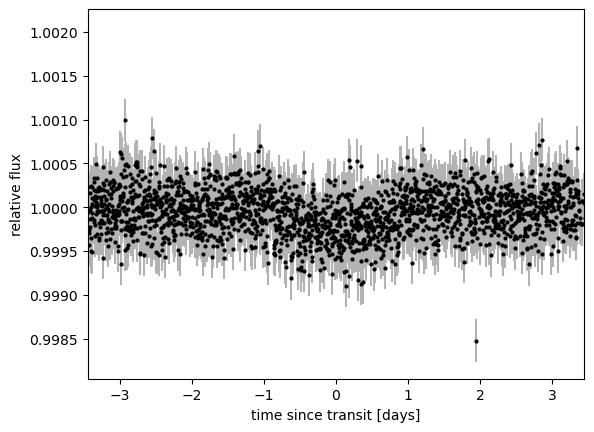

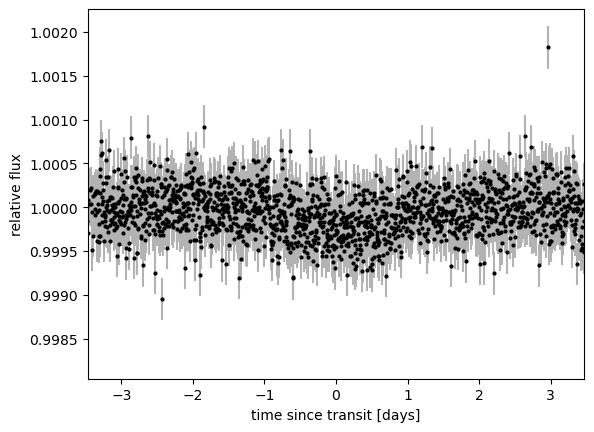

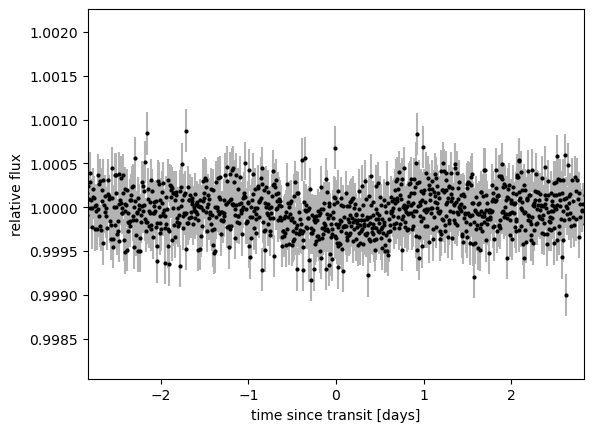

In [12]:
for i, letter in enumerate("bcd"):
    plt.figure()

    p = map_soln["P"][i]
    
    for inst in insts:
        name = inst["name"]
        mu = map_soln[name+"_mean"]
        sigma = map_soln[name+"_sigma"]
        lcs = map_soln[name+"_lc"]
        if npl > 1:
            other = lcs[:,(i+1) % npl]
        else:
            other = 0
        # NOTE: 't0' has already been subtracted!
        lc_fold = (inst["t_warp"][:, i] + 0.5*p) % p - 0.5*p
        lc_flux = inst["flux"] - mu - other
        plt.errorbar(lc_fold*24, lc_flux, yerr=np.sqrt(inst["err"]**2 + sigma**2), ms=ms, fmt=".k", zorder=-100, ecolor=ecolor)
        
    plt.xlim(-2*dur[i]*24, 2*dur[i]*24)
    plt.xlabel("time since transit [days]")
    plt.ylabel("relative flux")

In [13]:
with model:
    trace = pmx.sample(
        tune=1000,
        draws=1000,
        start=map_soln,
        cores=4,
        chains=4,
        target_accept=0.95,
        return_inferencedata=True,
    )

Multiprocess sampling (4 chains in 4 jobs)
NUTS: [120sec_sigma, 120sec_mean, tess_star, tts_2, tts_1, tts_0, b, ror]


/Users/mkuni/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/mkuni/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/mkuni/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/mkuni/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2551 seconds.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some

In [14]:
savefile = f"{tic}_ttv_short_nostellar.netcdf"
trace.to_netcdf(savefile,groups=["posterior","log_likelihood","sample_stats"])

'397362481_ttv_short_nostellar.netcdf'

In [9]:
savefile = f"{tic}_ttv_short_nostellar.netcdf"
trace = az.from_netcdf(savefile)

In [10]:
flat_samps = trace.posterior.stack(sample=("chain", "draw"))

In [11]:
def line(x, per, t0):
    return per*x + t0

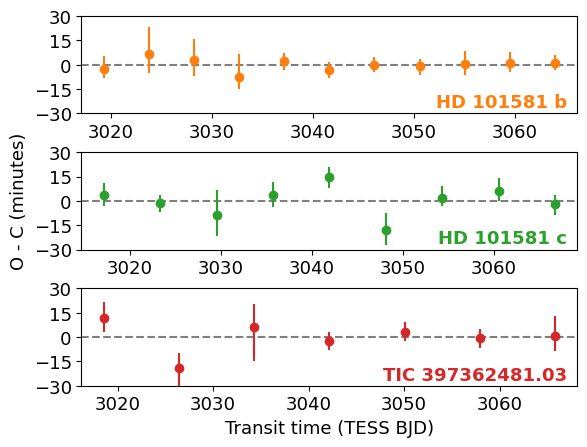

In [34]:
fs=13
colours = ["C1","C2","C3"]
names = ["HD 101581 b", "HD 101581 c", f"TIC {tic}.03"]

fig, ax = plt.subplots(3,1)
plt.subplots_adjust(hspace=0.4)

q = np.percentile(flat_samps["tts_0"], [15.9, 50, 84.1], axis=-1)
x = np.array(transit_inds[0])
popt = np.polyfit(x, q[1], 1)
y = line(x, *popt)
ax[0].errorbar(q[1], (q[1]-y)*24*60, yerr=[(q[1]-q[0])*24*60, (q[2]-q[1])*24*60], color=colours[0], fmt="o")

q = np.percentile(flat_samps["tts_1"], [15.9, 50, 84.1], axis=-1)
x = np.array(transit_inds[1])
popt = np.polyfit(x, q[1], 1)
y = line(x, *popt)
ax[1].errorbar(q[1], (q[1]-y)*24*60, yerr=[(q[1]-q[0])*24*60, (q[2]-q[1])*24*60], color=colours[1], fmt="o")

q = np.percentile(flat_samps["tts_2"], [15.9, 50, 84.1], axis=-1)
x = np.array(transit_inds[2])
popt = np.polyfit(x, q[1], 1)
y = line(x, *popt)
ax[2].errorbar(q[1], (q[1]-y)*24*60, yerr=[(q[1]-q[0])*24*60, (q[2]-q[1])*24*60], color=colours[2], fmt="o")

for i in [0,1,2]:
    ax[i].axhline(y=0, ls="--", color="0.5", zorder=-10)
    ax[i].set_yticks([-30,-15,0,15,30])
    ax[i].tick_params(axis='both', which='major', labelsize=fs)
    ax[i].set_ylim([-30,30])
    ax[i].text(0.98,0.02, names[i], fontweight="bold", color=colours[i],fontsize=fs, horizontalalignment='right',
     verticalalignment='bottom', transform=ax[i].transAxes)

    
ax[2].set_xlabel("Transit time (TESS BJD)",fontsize=fs)
ax[1].set_ylabel("O - C (minutes)",fontsize=fs)

plt.savefig("ttvs.png",dpi=300,bbox_inches="tight")

In [96]:
def jterm(n, j, a, b, P1, t01, P2, t02):
    sinterm = a*np.sin(j*2*np.pi*(t01 + n*P1 - t02)/P2)
    costerm = b*np.cos(j*2*np.pi*(t01 + n*P1 - t02)/P2)
    return sinterm + costerm

def harmonics_j1(n,
        a1, b1,
        P1=6.20425839,t01=3017.11161601,  
        P2=7.87105064,t02=3018.56755242):
    j1 = jterm(n, 1, a1, b1, P1, t01, P2, t02)
    return t01 + n*P1 + j1

def harmonics_j2(n,
        a1, b1, a2, b2,
        P1=6.20425839,t01=3017.11161601,  
        P2=7.87105064,t02=3018.56755242):
    j1 = jterm(n, 1, a1, b1, P1, t01, P2, t02)
    j2 = jterm(n, 2, a2, b2, P1, t01, P2, t02)
    return t01 + n*P1 + j1 + j2

def harmonics_j3(n,
        a1, b1, a2, b2, a3, b3,
        P1=6.20425839,t01=3017.11161601,  
        P2=7.87105064,t02=3018.56755242):
    j1 = jterm(n, 1, a1, b1, P1, t01, P2, t02)
    j2 = jterm(n, 2, a2, b2, P1, t01, P2, t02)
    j3 = jterm(n, 3, a3, b3, P1, t01, P2, t02)
    return t01 + n*P1 + j1 + j2 + j3

def harmonics_j4(n,
        a1, b1, a2, b2, a3, b3, a4, b4,
        P1=6.20425839,t01=3017.11161601,  
        P2=7.87105064,t02=3018.56755242):
    j1 = jterm(n, 1, a1, b1, P1, t01, P2, t02)
    j2 = jterm(n, 2, a2, b2, P1, t01, P2, t02)
    j3 = jterm(n, 3, a3, b3, P1, t01, P2, t02)
    j4 = jterm(n, 4, a4, b4, P1, t01, P2, t02)
    return t01 + n*P1 + j1 + j2 + j3 + j4

In [65]:
from scipy.optimize import curve_fit

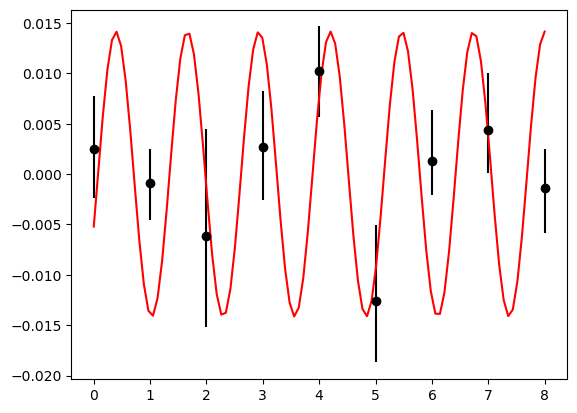

In [93]:
q = np.percentile(flat_samps["tts_1"], [15.9, 50, 84.1], axis=-1)

popt_line = np.polyfit(x, q[1], 1)

x = np.array(transit_inds[1])
y0 = line(x, *popt_line)

n = np.linspace(min(x), max(x), 100)

plt.errorbar(x, q[1]-y0, yerr=[q[1]-q[0], q[2]-q[1]], color="k", fmt="o")
#plt.errorbar(x, harmonics_j1(x, 0.01, 0.01)-y0, color="r", fmt="o")
plt.plot(n, harmonics_j1(n, 0.01, 0.01)-line(n, *popt_line), "r")

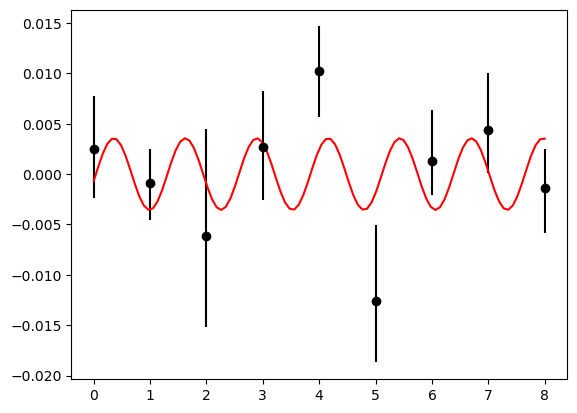

In [94]:
popt, pcov = curve_fit(harmonics_j1, x, y, p0=[0.01, 0.01])

plt.errorbar(x, q[1]-y0, yerr=[q[1]-q[0], q[2]-q[1]], color="k", fmt="o")
plt.plot(n, harmonics_j1(n, *popt)-line(n, *popt_line), "r")

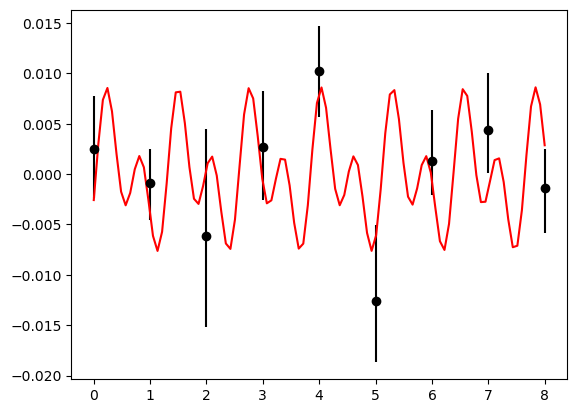

In [95]:
popt, pcov = curve_fit(harmonics_j2, x, y, p0=[0.01, 0.01, 0.01, 0.01])

plt.plot(x, y-y0, "k.")
plt.errorbar(x, q[1]-y0, yerr=[q[1]-q[0], q[2]-q[1]], color="k", fmt="o")
plt.plot(n, harmonics_j2(n, *popt)-line(n, *popt_line), "r")

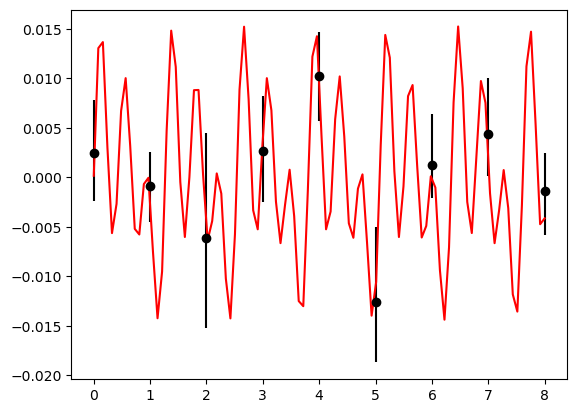

In [97]:
popt, pcov = curve_fit(harmonics_j3, x, y, p0=[0.01, 0.01, 0.01, 0.01, 0.01, 0.01])

plt.plot(x, y-y0, "k.")
plt.errorbar(x, q[1]-y0, yerr=[q[1]-q[0], q[2]-q[1]], color="k", fmt="o")
plt.plot(n, harmonics_j3(n, *popt)-line(n, *popt_line), "r")

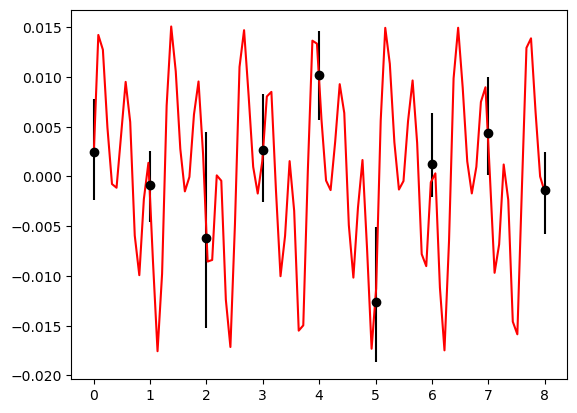

In [98]:
popt, pcov = curve_fit(harmonics_j4, x, y, p0=[0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01])

plt.plot(x, y-y0, "k.")
plt.errorbar(x, q[1]-y0, yerr=[q[1]-q[0], q[2]-q[1]], color="k", fmt="o")
plt.plot(n, harmonics_j4(n, *popt)-line(n, *popt_line), "r")

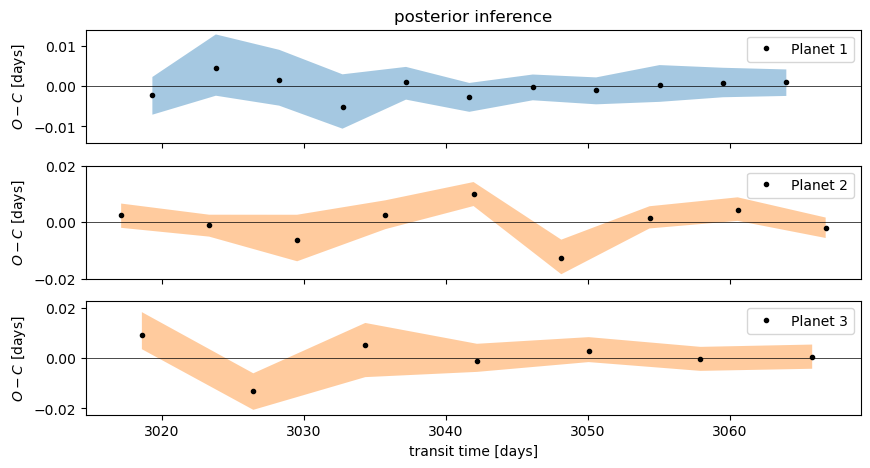

In [10]:
colours = ["C1","C2", "C3"]
ecolor="0.7"
ms=8
fs=16
btime = 30

fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 5), sharex=True)

q = np.percentile(flat_samps["ttvs_0"], [16, 50, 84], axis=-1)
ax1.fill_between(
    np.median(flat_samps["tts_0"], axis=-1),
    q[0],
    q[2],
    color="C0",
    alpha=0.4,
    edgecolor="none",
)
ax1.plot(np.median(flat_samps["tts_0"], axis=-1), q[1], "k.", label="Planet 1")
ax1.axhline(0, color="k", lw=0.5)
ax1.set_ylim(np.max(np.abs(ax1.get_ylim())) * np.array([-1, 1]))
ax1.legend()
ax1.set_ylabel("$O-C$ [days]")

q = np.percentile(flat_samps["ttvs_1"], [16, 50, 84], axis=-1)
ax2.fill_between(
    np.median(flat_samps["tts_1"], axis=-1),
    q[0],
    q[2],
    color="C1",
    alpha=0.4,
    edgecolor="none",
)
ax2.plot(np.median(flat_samps["tts_1"], axis=-1), q[1], "k.", label="Planet 2")
ax2.axhline(0, color="k", lw=0.5)
ax2.set_ylim(np.max(np.abs(ax2.get_ylim())) * np.array([-1, 1]))
ax2.legend()
ax2.set_ylabel("$O-C$ [days]")

q = np.percentile(flat_samps["ttvs_2"], [16, 50, 84], axis=-1)
ax3.fill_between(
    np.median(flat_samps["tts_2"], axis=-1),
    q[0],
    q[2],
    color="C1",
    alpha=0.4,
    edgecolor="none",
)
ax3.plot(np.median(flat_samps["tts_2"], axis=-1), q[1], "k.", label="Planet 3")
ax3.axhline(0, color="k", lw=0.5)
ax3.set_ylim(np.max(np.abs(ax3.get_ylim())) * np.array([-1, 1]))
ax3.legend()
ax3.set_ylabel("$O-C$ [days]")

ax3.set_xlabel("transit time [days]")
_ = ax1.set_title("posterior inference")

In [11]:
flat_samps = trace.posterior.stack(sample=("chain", "draw"))

fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 5), sharex=True)

q = np.percentile(flat_samps["ttvs_0"], [16, 50, 84], axis=-1)
ax1.errorbar(np.median(flat_samps["tts_0"], axis=-1), q[1], yerr=[q[1]-q[0],q[2]-q[1]], fmt="o", label="Planet 1")
ax1.axhline(0, color="k", lw=0.5)
ax1.set_ylim(np.max(np.abs(ax1.get_ylim())) * np.array([-1, 1]))
ax1.legend()
ax1.set_ylabel("$O-C$ [days]")

q = np.percentile(flat_samps["ttvs_1"], [16, 50, 84], axis=-1)
ax2.errorbar(np.median(flat_samps["tts_1"], axis=-1), q[1], yerr=[q[1]-q[0],q[2]-q[1]], fmt="o", label="Planet 2")
ax2.axhline(0, color="k", lw=0.5)
ax2.set_ylim(np.max(np.abs(ax2.get_ylim())) * np.array([-1, 1]))
ax2.legend()
ax2.set_ylabel("$O-C$ [days]")

q = np.percentile(flat_samps["ttvs_2"], [16, 50, 84], axis=-1)
ax3.errorbar(np.median(flat_samps["tts_2"], axis=-1), q[1], yerr=[q[1]-q[0],q[2]-q[1]], fmt="o", label="Planet 3")
ax3.axhline(0, color="k", lw=0.5)
ax3.set_ylim(np.max(np.abs(ax3.get_ylim())) * np.array([-1, 1]))
ax3.legend()
ax3.set_ylabel("$O-C$ [days]")

ax3.set_xlabel("transit time [days]")
_ = ax1.set_title("posterior inference")

In [17]:
var_names = ["tts_0"]

corner.corner(trace, var_names=var_names)
az.summary(trace, var_names=var_names)

mean     sd    hdi_3%   hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
tts_0[0]   3019.316  0.005  3019.308  3019.327        0.0      0.0    2173.0   
tts_0[1]   3023.789  0.010  3023.773  3023.810        0.0      0.0    2105.0   
tts_0[2]   3028.251  0.007  3028.238  3028.265        0.0      0.0    2139.0   
tts_0[3]   3032.710  0.007  3032.699  3032.723        0.0      0.0    1885.0   
tts_0[4]   3037.181  0.004  3037.173  3037.189        0.0      0.0    3458.0   
tts_0[5]   3041.643  0.004  3041.634  3041.651        0.0      0.0    2799.0   
tts_0[6]   3046.110  0.003  3046.104  3046.117        0.0      0.0    3982.0   
tts_0[7]   3050.575  0.004  3050.567  3050.581        0.0      0.0    3764.0   
tts_0[8]   3055.042  0.006  3055.032  3055.052        0.0      0.0    3127.0   
tts_0[9]   3059.508  0.004  3059.500  3059.516        0.0      0.0    2920.0   
tts_0[10]  3063.973  0.003  3063.967  3063.980        0.0      0.0    2728.0   

           ess_tail  r_hat  
tts_0[0]     2035.0    1.0  
tts_0[1]     1525.0    1.0  
tts_0[2]     2833.0    1.0  
tts_0[3]     3396.0    1.0  
tts_0[4]     1918.0    1.0  
tts_0[5]     1724.0    1.0  
tts_0[6]     2856.0    1.0  
tts_0[7]     2160.0    1.0  
tts_0[8]     2127.0    1.0  
tts_0[9]     2737.0    1.0  
tts_0[10]    1305.0    1.0

In [18]:
var_names = ["tts_1"]

corner.corner(trace, var_names=var_names)
az.summary(trace, var_names=var_names)

mean     sd    hdi_3%   hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
tts_1[0]  3017.114  0.006  3017.104  3017.126        0.0      0.0    2830.0   
tts_1[1]  3023.315  0.004  3023.308  3023.322        0.0      0.0    3577.0   
tts_1[2]  3029.515  0.009  3029.501  3029.530        0.0      0.0    1487.0   
tts_1[3]  3035.727  0.005  3035.718  3035.737        0.0      0.0    2084.0   
tts_1[4]  3041.939  0.005  3041.930  3041.948        0.0      0.0    2657.0   
tts_1[5]  3048.121  0.007  3048.107  3048.134        0.0      0.0    2879.0   
tts_1[6]  3054.339  0.005  3054.331  3054.349        0.0      0.0    2012.0   
tts_1[7]  3060.546  0.005  3060.538  3060.556        0.0      0.0    2416.0   
tts_1[8]  3066.744  0.004  3066.736  3066.751        0.0      0.0    2770.0   

          ess_tail  r_hat  
tts_1[0]    1531.0    1.0  
tts_1[1]    2515.0    1.0  
tts_1[2]    3208.0    1.0  
tts_1[3]    2400.0    1.0  
tts_1[4]    2158.0    1.0  
tts_1[5]    2504.0    1.0  
tts_1[6]    1381.0    1.0  
tts_1[7]    3114.0    1.0  
tts_1[8]    2684.0    1.0

In [19]:
var_names = ["tts_2"]

corner.corner(trace, var_names=var_names)
az.summary(trace, var_names=var_names)

mean     sd    hdi_3%   hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
tts_2[0]  3018.576  0.007  3018.562  3018.588      0.000    0.000    2406.0   
tts_2[1]  3026.416  0.038  3026.359  3026.445      0.012    0.009      19.0   
tts_2[2]  3034.305  0.039  3034.263  3034.338      0.003    0.002     359.0   
tts_2[3]  3042.179  0.004  3042.171  3042.187      0.000    0.000    3687.0   
tts_2[4]  3050.054  0.004  3050.046  3050.062      0.000    0.000    2372.0   
tts_2[5]  3057.922  0.005  3057.914  3057.931      0.000    0.000    2637.0   
tts_2[6]  3065.795  0.007  3065.783  3065.809      0.000    0.000    1992.0   

          ess_tail  r_hat  
tts_2[0]    1767.0   1.00  
tts_2[1]      12.0   1.15  
tts_2[2]     156.0   1.01  
tts_2[3]    2071.0   1.00  
tts_2[4]    2289.0   1.00  
tts_2[5]    1530.0   1.00  
tts_2[6]    3013.0   1.00

In [20]:
for i in range(npl):
    map_soln["P"][i] = np.median(flat_samps["P"][i])
    map_soln["t0"][i] = np.median(flat_samps["t0"][i])
    map_soln["ror"][i] = np.median(flat_samps["ror"][i])
    map_soln["b"][i] = np.median(flat_samps["b"][i])
    map_soln["r_pl"][i] = np.median(flat_samps["r_pl"][i])
    map_soln[f"ttvs_{i}"] = np.nanmedian(flat_samps[f"ttvs_{i}"], axis=-1)
    map_soln[f"tts_{i}"] = np.nanmedian(flat_samps[f"tts_{i}"], axis=-1)

In [21]:
with model:
    t_warp = pmx.eval_in_model(orbitTransit._warp_times(t_plot), map_soln)
    for inst in insts:
        inst["t_warp"] = pmx.eval_in_model(orbitTransit._warp_times(inst["time"]), map_soln)

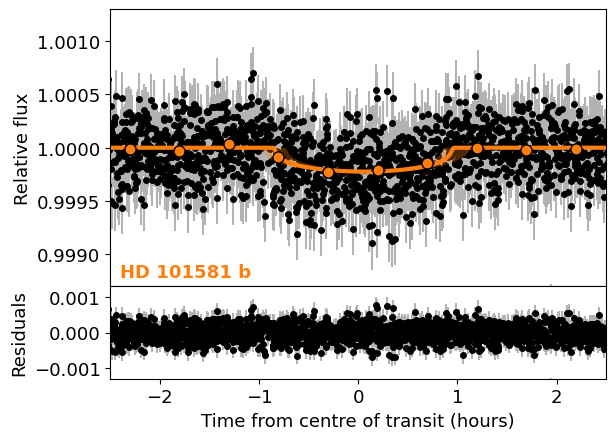

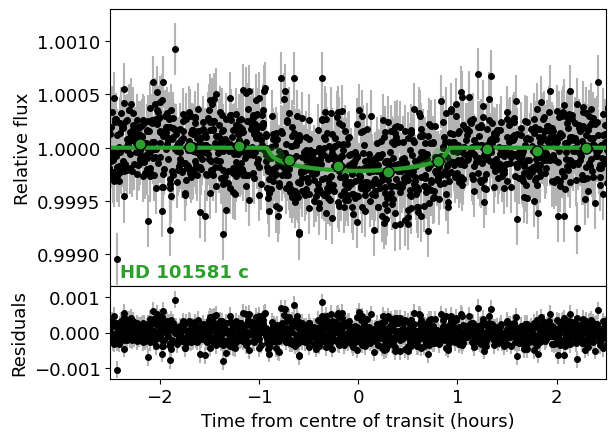

In [22]:
colours = ["C1","C2","C3"]
names = ["HD 101581 b", "HD 101581 c", f"TIC {tic}.03"]
ecolor="0.7"
ms=8
fs=13
btime = 30

for i in range(npl):
    fig = plt.figure()
    spec = fig.add_gridspec(ncols=1, nrows=4, wspace=0, hspace=0)
    ax0 = fig.add_subplot(spec[:3, :])
    ax1 = fig.add_subplot(spec[3, :])
    
    p = np.median(flat_samps["P"][i])
    t0 = np.median(flat_samps["t0"][i])
    
    # Plot the folded light curve
    lc_folds = []
    lc_fluxes = []
    lc_errs = []
    lc_models = []
    for inst in insts:
        name = inst["name"]
        mu = np.median(flat_samps[name+"_mean"])
        sigma = np.median(flat_samps[name+"_sigma"])
        lcs = trace.posterior[name+"_lc"].values
        if npl > 1:
            other = np.median(lcs[:,:,:,(i + 1) % npl], axis=(0, 1))
        else:
            other = 0
        lc_fold = (inst["t_warp"][:,i] + 0.5*p) % p - 0.5*p
        lc_flux = inst["flux"] - mu - other
        lc_err = np.sqrt(inst["err"]**2 + sigma**2)
        lc_model = np.median(trace.posterior[f"{name}_lc_model"].values, axis=(0, 1))
        
        lc_folds.append(lc_fold)
        lc_fluxes.append(lc_flux)
        lc_errs.append(lc_err)
        lc_models.append(lc_model)
    
    lc_fold = np.concatenate(lc_folds)
    lc_flux = np.concatenate(lc_fluxes)
    lc_err = np.concatenate(lc_errs)
    lc_model = np.concatenate(lc_models)

    ax0.errorbar(lc_fold*24, lc_flux, yerr=lc_err, ms=ms, fmt=".k", zorder=-100, ecolor=ecolor)
    
    # Plot the folded model
    lcs = trace.posterior[name+"_lc_plot"]
    lc_plot_fold = (t_warp[:,i] + 0.5*p) % p - 0.5*p
    inds = np.argsort(lc_plot_fold)
    pred = lcs[:, :, inds, i]
    pred = 1 + np.percentile(pred, [15.9, 50, 84.1], axis=(0, 1))
        
    ax0.plot(lc_plot_fold[inds]*24, pred[1], color=colours[i], lw=3)
    art = ax0.fill_between(lc_plot_fold[inds]*24, pred[0], pred[2], color=colours[i], alpha=0.3)
    art.set_edgecolor("none")

    # Plot binned data
    bins=np.arange(min(lc_fold),max(lc_fold),btime/60./24.)
    bin_means, bin_edges, _ = binned_statistic(lc_fold, lc_flux,statistic='mean', bins=bins)
    bin_width = (bin_edges[1] - bin_edges[0])
    bin_centres = bin_edges[1:] - bin_width/2
    ax0.errorbar(bin_centres*24, bin_means, yerr=0,fmt='o', color="k",mfc=colours[i],capsize=5, ms=8)

    ax0.set_ylim([0.9987,1.0013])
    ax0.set_xlim([-2.5, 2.5])
    ax0.set_ylabel("Relative flux",fontsize=fs)
    
    # Plot residuals
    ax1.errorbar(lc_fold*24, lc_flux - lc_model - 1, yerr=lc_err, fmt=".k",capsize=0, ms=ms, ecolor=ecolor)
    ax1.set_xlabel("Time from center of transit (hours)",fontsize=12)
    ax1.axhline(y=0,color=colours[i])
    
    ax1.set_ylim([-0.0013, 0.0013])
    ax1.set_xlim([-2.5, 2.5])
    ax1.set_ylabel("Residuals",fontsize=fs)

    ax1.set_xlabel("Time from centre of transit (hours)",fontsize=fs)
    ax0.text(0.02,0.02, names[i], fontweight="bold", color=colours[i],fontsize=fs, horizontalalignment='left',
     verticalalignment='bottom', transform=ax0.transAxes)
    ax0.tick_params(axis='both', which='major', labelsize=fs)
    ax1.tick_params(axis='both', which='major', labelsize=fs)

    plt.savefig(f"planet{i}_ttv.png",dpi=150,bbox_inches="tight")